This week, I found myself wanting to do some computation over pixels in an image.

This image, in fact

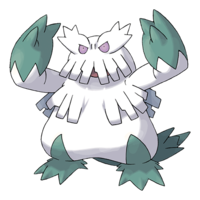

In [1]:
from PIL import Image
im = Image.open('images/Abomasnow.png')
im

In particular, I wanted to run K-means clustering over the image to determine what the 3 most popular colors were-- visually, I expected to see something like green, white, and maybe pink/gray(?)

### A First Pass

I load my `Image` object into `numpy.array` that `sklearn` can eat

In [2]:
import numpy as np

arr = np.array(im)

It's a 200 by 200 image, so this should work pretty quickly.

In [3]:
arr.shape

(200, 200, 4)

Building and training the model is easy enough.

We want a `KMeans` object instantiated with 3 means.

In [4]:
from sklearn.cluster import KMeans

model = KMeans(3)

Next, we're going to take our `200 x 200 x (RGB)` values and put them into one, `40000 x 3` matrix (pixel location doesn't matter for K-means)

In [5]:
reshaped_arr = arr[:, :, :3].reshape(-1, 3)
reshaped_arr.shape

(40000, 3)

Fit the model

In [6]:
model.fit(arr[:, :, :3].reshape(-1, 3))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Aaaaaand our means

In [7]:
model.cluster_centers_

array([[105.41553813, 132.43644571, 131.09289617],
       [232.71566397, 231.75916993, 235.93683444],
       [  1.47778587,   1.78674436,   1.75863074]])

We've got gray

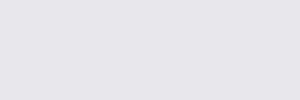

In [8]:
Image.new('RGB', (300, 100), color=(232, 231, 235))

Greenish

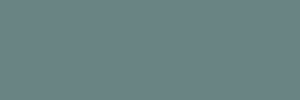

In [9]:
Image.new('RGB', (300, 100), color=(105, 132, 131))

And... black?

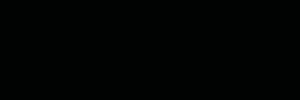

In [10]:
Image.new('RGB', (300, 100), color=(1, 2, 2))

What happened?

### Did You Catch the Spoiler?

Let's go back to our image array. We had a 4th value in our 3rd dimension. The first 3 account for R, G, and B. But the *fourth* represents **alpha** or the transparency.

In [11]:
arr.shape

(200, 200, 4)

The image printed out nicely enough when we loaded it up

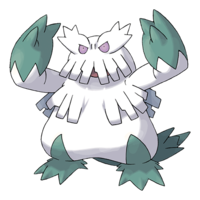

In [12]:
im

But if you were to open it up in some alpha-channel-aware software, like [paint.net](https://www.getpaint.net/), you'd see that the background was actually transparent.

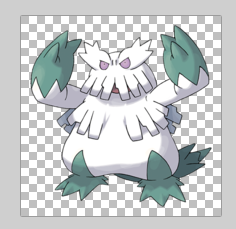

In [13]:
Image.open('images/alpha_channel.PNG')

Indeed, if you inspect a random pixel in the upper-left corner of this image, you'll see that it's got a `0` value for its alpha channel at the end, but critically, *it gives us `0, 0, 0` RGB values*. In other words, `numpy` thinks that like 40% of this picture is pure black.

In [14]:
arr[10, 10]

array([0, 0, 0, 0], dtype=uint8)

### Clearing out the Clear

So we want to re-run our clustering algorithm, this time only considering pixles with the **max** value for the alpha channel, `255`

And so we'll line all of the pixels up once more (including the alpha channel for the next step)

In [15]:
all_pixels = arr.reshape(-1, 4)
all_pixels.shape

(40000, 4)

Then some basic `numpy` array filtering reveals that my 40% was actually closer to like 60-something

In [16]:
just_non_alpha = all_pixels[all_pixels[:, 3] == 255]
just_non_alpha.shape

(18747, 4)

Refitting the model, we get new centers. Promising.

In [17]:
model = KMeans(3)

model.fit(just_non_alpha)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [18]:
model.cluster_centers_

array([[182.57885015, 183.38536135, 194.31147541, 255.        ],
       [252.58630872, 252.45704698, 252.62241611, 255.        ],
       [100.3142406 , 130.10723514, 128.00387597, 255.        ]])

Again, we've got greenish

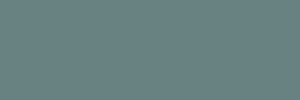

In [19]:
Image.new('RGB', (300, 100), color=(103, 130, 129))

Gray

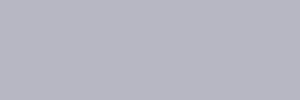

In [20]:
Image.new('RGB', (300, 100), color=(182, 183, 194))

... and very, very white.

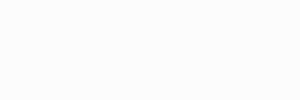

In [21]:
Image.new('RGB', (300, 100), color=(252, 252, 252))

Oh well. The dude's a snowman. Go figure. At least this one makes sense.